In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CTD = xr.open_dataset("dfo-bb046-20201006_Hakai_shipCTD.nc")

In [3]:
glider = xr.open_dataset("dfo-bb046-20201006_L2_modified.nc")

In [4]:
index = glider.profile_index
depth = glider.depth
oxygen = glider.oxygen_concentration

## Question 1
make a pandas dataframe of the important variables

In [5]:
d = {'lat':glider.latitude, 'lon':glider.longitude, 'depth':glider.depth, 'pressure':glider.pressure, 'oxygen':glider.oxygen_concentration,'salinity':glider.salinity,'temperature':glider.temperature,'conductivity':glider.conductivity,'profile_index':glider.profile_index}
df = pd.DataFrame(data=d)

#### turn any field with salinity < 25 to nan

In [6]:
df.salinity = np.where(df.salinity > 25, df.salinity, np.nan)
df.dropna(inplace=True)

In [7]:
df

lat         lon     depth  pressure      oxygen   salinity  \
93       51.721033 -128.060080  4.173378      4.21  349.694808  29.774116   
94       51.721033 -128.060079  5.164666      5.21  348.997599  28.418583   
95       51.721033 -128.060078  5.987432      6.04  348.296959  29.698581   
96       51.721033 -128.060077  6.730893      6.79  347.601809  29.712849   
97       51.721033 -128.060076  7.414874      7.48  346.901855  29.700029   
...            ...         ...       ...       ...         ...        ...   
1871749  51.728488 -128.039263  1.001222      1.01  308.381194  28.928762   
1871750  51.728486 -128.039265  1.090439      1.10  308.395831  28.933442   
1871751  51.728483 -128.039267  1.040874      1.05  308.410527  28.938227   
1871756  51.728475 -128.039280  1.070613      1.08  308.483917  28.954816   
1871758  51.728471 -128.039285  1.030961      1.04  308.495703  28.967311   

         temperature  conductivity  profile_index  
93           13.2450       3.57843            0.0  
94           12.8710       3.40143            0.0  
95           12.7500       3.52922            0.0  
96           12.6983       3.52637            0.0  
97           12.6608       3.52179            0.0  
...              ...           ...            ...  
1871749      10.2224       3.22636          901.0  
1871750      10.2217       3.22678          901.0  
1871751      10.2203       3.22715          901.0  
1871756      10.2190       3.22872          901.0  
1871758      10.2184       3.22993          901.0  

[1832800 rows x 9 columns]

#### lets plot a few profiles

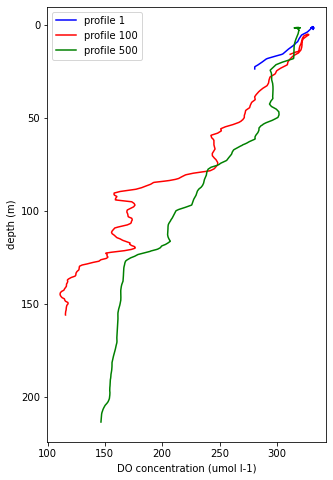

In [8]:
fig, ax = plt.subplots(1,1,figsize=(5,8))
ax.plot(df.oxygen[df.profile_index==1.0],df.depth[df.profile_index==1.0], 'b',label='profile 1')
ax.plot(df.oxygen[df.profile_index==100.0],df.depth[df.profile_index==100.0],'r',label='profile 100')
ax.plot(df.oxygen[df.profile_index==500.0],df.depth[df.profile_index==500.0],'g',label='profile 500')
ax.legend()
ax.set_ylabel('depth (m)')
ax.set_xlabel('DO concentration (umol l-1)')
ax.invert_yaxis()

#### In general terms, explain the dominant processes leading to the observed oxygen profiles?
Air-sea exchange leads to the highest oxygen concetration near the surface (top of the profiles). While mixing and diffusion do transport oxygen rich water further down, less oxygen is available as you go deeper into the water column. Biological processes that consume oxygen are less productive where there is less light available, which might explain why at a depth of about 125 m, the oxygen concentration in profile 500 stops decreasing. 

# Question 2

In [9]:
B0 = -6.4523*10**-3
B1 = -7.37614*10**-3
B2 = -1.03410*10**-2
B3 = -8.17083*10**-3
C0 = -4.88682*10**-7

D0 = 24.4543
D1 = -67.4509
D2 = -4.8489
D3 = -5.44*10**4

In [10]:
Ts = np.log((298.15-df.temperature)/(273.15+df.temperature))

In [11]:
Tabs = df.temperature + 273.15

In [12]:
Spreset = 0
Sref = 0

In [13]:
def partial_pressure(salinity):
    p= 1013.25*np.e**(D0+D1*(100/Tabs)+D2*np.log(Tabs/100)+D3*salinity)
    return p

In [14]:
A = (1013.25-partial_pressure(Spreset))/1013.25-partial_pressure(df.salinity)

In [15]:
Scorr = A*np.e**((df.salinity-Sref)*(B0+B1*Ts+B2*Ts**2+B3*Ts**3)+C0*(df.salinity**2-Sref**2))

In [16]:
#salinity corrected DO
DOs = df.oxygen*Scorr

In [17]:
Pcoef2 = 0.00025
Pcoef3 = 0.0328

In [18]:
df['DOsp'] = DOs*(1+((Pcoef2*df.temperature + Pcoef3)*df.pressure)/1000)

In [19]:
df

lat         lon     depth  pressure      oxygen   salinity  \
93       51.721033 -128.060080  4.173378      4.21  349.694808  29.774116   
94       51.721033 -128.060079  5.164666      5.21  348.997599  28.418583   
95       51.721033 -128.060078  5.987432      6.04  348.296959  29.698581   
96       51.721033 -128.060077  6.730893      6.79  347.601809  29.712849   
97       51.721033 -128.060076  7.414874      7.48  346.901855  29.700029   
...            ...         ...       ...       ...         ...        ...   
1871749  51.728488 -128.039263  1.001222      1.01  308.381194  28.928762   
1871750  51.728486 -128.039265  1.090439      1.10  308.395831  28.933442   
1871751  51.728483 -128.039267  1.040874      1.05  308.410527  28.938227   
1871756  51.728475 -128.039280  1.070613      1.08  308.483917  28.954816   
1871758  51.728471 -128.039285  1.030961      1.04  308.495703  28.967311   

         temperature  conductivity  profile_index        DOsp  
93           13.2450       3.57843            0.0  284.486949  
94           12.8710       3.40143            0.0  286.370206  
95           12.7500       3.52922            0.0  283.430672  
96           12.6983       3.52637            0.0  282.838258  
97           12.6608       3.52179            0.0  282.293128  
...              ...           ...            ...         ...  
1871749      10.2224       3.22636          901.0  251.756689  
1871750      10.2217       3.22678          901.0  251.761535  
1871751      10.2203       3.22715          901.0  251.764876  
1871756      10.2190       3.22872          901.0  251.797240  
1871758      10.2184       3.22993          901.0  251.785625  

[1832800 rows x 10 columns]

## Question 3

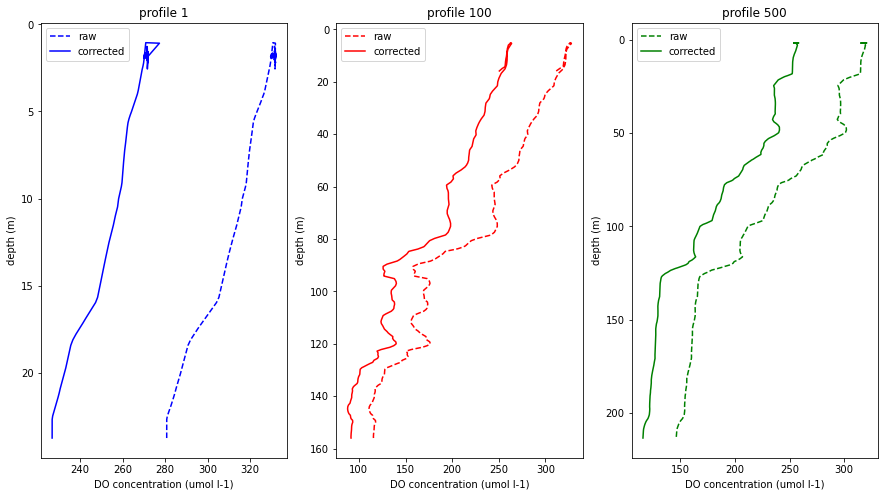

In [20]:
fig, ax = plt.subplots(1,3,figsize=(15,8))

ax[0].plot(df.oxygen[df.profile_index==1.0],df.depth[df.profile_index==1.0], 'b--', label='raw')
ax[0].plot(df.DOsp[df.profile_index==1.0],df.depth[df.profile_index==1.0],'b', label='corrected')
ax[0].legend()
ax[0].set_title('profile 1')
ax[0].set_ylabel('depth (m)')
ax[0].set_xlabel('DO concentration (umol l-1)')
ax[0].invert_yaxis()

ax[1].plot(df.oxygen[df.profile_index==100.0],df.depth[df.profile_index==100.0], 'r--', label='raw')
ax[1].plot(df.DOsp[df.profile_index==100.0],df.depth[df.profile_index==100.0],'r', label='corrected')
ax[1].legend()
ax[1].set_title('profile 100')
ax[1].set_ylabel('depth (m)')
ax[1].set_xlabel('DO concentration (umol l-1)')
ax[1].invert_yaxis()

ax[2].plot(df.oxygen[df.profile_index==500.0],df.depth[df.profile_index==500.0], 'g--', label='raw')
ax[2].plot(df.DOsp[df.profile_index==500.0],df.depth[df.profile_index==500.0],'g', label='corrected')
ax[2].legend()
ax[2].set_title('profile 500')
ax[2].set_ylabel('depth (m)')
ax[2].set_xlabel('DO concentration (umol l-1)')
ax[2].invert_yaxis()

Text(0.5, 0, 'Change in DO concentration (umol l-1)')

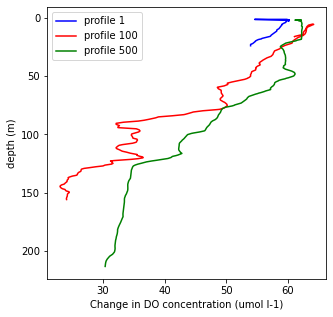

In [21]:
# interested to also plot difference
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(df.oxygen[df.profile_index==1.0]-df.DOsp[df.profile_index==1.0], df.depth[df.profile_index==1.0], 'b', label='profile 1')
ax.plot(df.oxygen[df.profile_index==100.0]-df.DOsp[df.profile_index==100.0], df.depth[df.profile_index==100.0], 'r', label='profile 100')
ax.plot(df.oxygen[df.profile_index==500.0]-df.DOsp[df.profile_index==500.0], df.depth[df.profile_index==500.0], 'g', label='profile 500')
ax.invert_yaxis()
ax.legend()
ax.set_ylabel('depth (m)')
ax.set_xlabel('Change in DO concentration (umol l-1)')

#### What are the main differences, and what does this tell you about the effects of salinity on oxygen solubility in water?
The main change is that the corrected DO concentration is significantly smaller (65-22 umol/L) than the initially calculated one. This shows that oxygen is less soluble at higher salinities. 

## Question 4

In [22]:
lat =51.72143069
lon =-128.0582176
diff_lon = np.abs(df.lon - lon)
diff_lat = np.abs(df.lat - lat)

print(df.profile_index[np.argmin(diff_lon+diff_lat)])
print(df.lat[np.argmin(diff_lon+diff_lat)])
print(df.lon[np.argmin(diff_lon+diff_lat)])

2.0
51.72211666666667
-128.05902417188605


In [23]:
gliderO2 = df.DOsp[df.profile_index==2.0]
gliderD =  df.depth[df.profile_index==2.0]

In [35]:
# convert glider units from umol/l to ml/l using the ideal gas law
R = 8.31446261815324 # [m3 Pa K-1 mol-1]
# pressure is in dbar convert to Pa = dbar*10000
# umol*10**-6 = mol
# mL = m3*10**6 -> cancels out umol conversion
# gliderO2 = ((gliderO2)*R*(df.temperature[df.profile_index==2.0]+273.15))/(df.pressure[df.profile_index==2.0]*10000)
# ctdO2 = ((CTD.Dissolved_O2*10**-6)*(CTD.Pressure*10000))/(R*(CTD.Temperature+273.15))*(10**6)

#even though gas concentration IS pressure dependent it doesnt look liek the measurement is pressure dependent!
ctd_O2 = (CTD.Dissolved_O2*1e-3/22.4)*1e6 # micromol/L, based on 1 mole of an ideal gas at standard temperature and pressure (0 °C, 1 atm) =22.41 L per mole

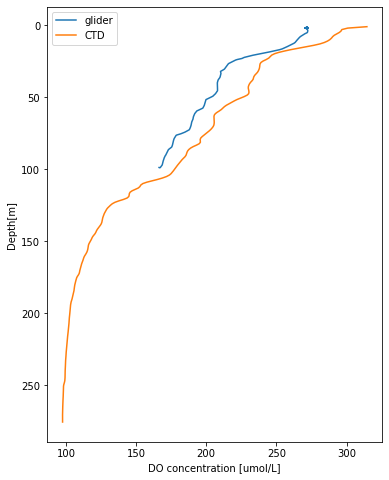

In [33]:
fig, ax = plt.subplots(1,1,figsize=(6,8))
ax.plot(gliderO2, gliderD, label='glider')
ax.plot(ctd_O2, CTD.Depth, label='CTD')
ax.set_ylabel('Depth[m]')
ax.set_xlabel('DO concentration [umol/L]')
ax.legend()
ax.invert_yaxis()

In [26]:
# lets just look at the ctd data that fits into the depth range that the glider data is in
ctd_O2_trim = ctd_O2[(CTD.Depth > min(gliderD))][CTD.Depth[1:] < max(gliderD)]
depth_trim = CTD.Depth[(CTD.Depth > min(gliderD))][CTD.Depth[1:] < max(gliderD)]

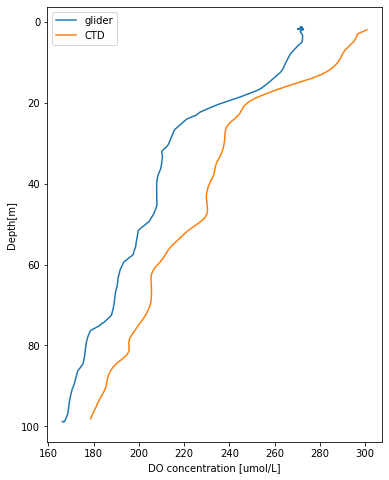

In [27]:
fig, ax = plt.subplots(1,1,figsize=(6,8))
ax.plot(gliderO2, gliderD, label='glider')
ax.plot(ctd_O2_trim, depth_trim, label='CTD')
ax.set_ylabel('Depth[m]')
ax.set_xlabel('DO concentration [umol/L]')
ax.legend()
ax.invert_yaxis()

In [28]:
#looks like the glider data needs to be corrected in depth AND in O2 measurement 
#decrease the depths of the O2 measurement until the standard deviation is minimizeddiff = np.zeros(len(ctd_O2_trim))
diff = np.zeros(len(ctd_O2_trim))
for j in range(10):
    for i in range(len(ctd_O2_trim)):
        diff_depth = np.abs((gliderD.values-j)-depth_trim.values[i])
        diff[i] = ctd_O2_trim[i].values - gliderO2.values[np.argmin(diff_depth)]
    print("depth offset= "+str(j)+", std= "+str(np.std(diff))+", mean= "+str(np.mean(diff)))

depth offset= 0, std= 4.6925393775077, mean= 18.419925893712392
depth offset= 1, std= 4.388111641992732, mean= 19.49869152998152
depth offset= 2, std= 4.319586205038034, mean= 20.57722075019967
depth offset= 3, std= 4.511146694476402, mean= 21.670888741820104
depth offset= 4, std= 4.960549004862758, mean= 22.75033729792675
depth offset= 5, std= 5.557663235605326, mean= 23.81049674957401
depth offset= 6, std= 6.251224675258285, mean= 24.83854258164532
depth offset= 7, std= 7.038223366406917, mean= 25.880415917613636
depth offset= 8, std= 7.8601000574437325, mean= 26.89810248671627
depth offset= 9, std= 8.697683962936289, mean= 27.896920557888627


#### based on the stadnard deviation and the average difference, the difference between the two tracks is minimized when the depth of the glider is decreased by two meters and  ~20.6 umol/L is added to the glider O2 measurement

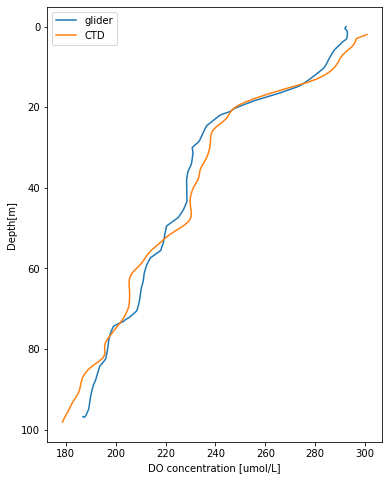

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6,8))
ax.plot(gliderO2[gliderD-2 > 0]+20.57722075019967, gliderD[gliderD-2 > 0]-2, label='glider')
ax.plot(ctd_O2_trim, depth_trim, label='CTD')
ax.set_ylabel('Depth[m]')
ax.set_xlabel('DO concentration [umol/L]')
ax.legend()
ax.invert_yaxis()

#### Explain how you calculated the corrections and your reasoning for this method.
First I trimmed the CTD data such that I was only comparing depths where both the CTD data and the glider overlapped. Then, based upon the plots of this trimmed data, I noticed that the two profiles had very similar shapes, and changed at about the same rate with depth. Thus, I decided that the glider data was jsut offeset from the CTD data, so the correction had to simply be a shift as opposed to a multiplication or division type correction.<br>
Again based on the plots, it looked to me that the glider data had to be both decreased in depth and increased in DO concentration. I used a "for loop" to test the standard deviation of the difference the CTD data and the glider data at the same (or very similar) depth for decreases in depth between 0 and 10 meters. This process showed that a decrease in depth of 2 meters had the lower standard deviation around the mean difference of 20.58 umol/L. As such, the glider data was calibrated by subtrating 2 m from the depth (and removing any data points with a negative depth) and adding 20.58 umol/L to the DO concentration. 

## Question 5

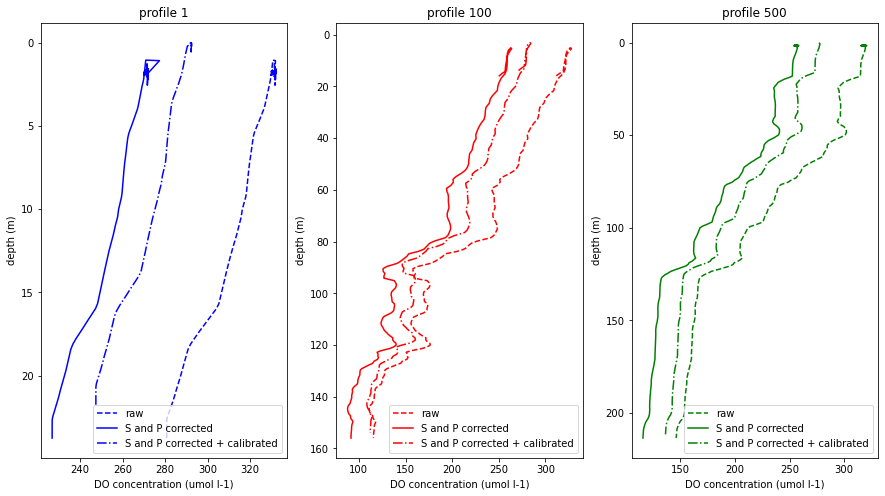

In [30]:
fig, ax = plt.subplots(1,3,figsize=(15,8))

ax[0].plot(df.oxygen[df.profile_index==1.0],df.depth[df.profile_index==1.0], 'b--', label='raw')
ax[0].plot(df.DOsp[df.profile_index==1.0],df.depth[df.profile_index==1.0],'b', label='S and P corrected')
ax[0].plot(df.DOsp[df.profile_index==1.0][df.depth[df.profile_index==1.0]-2 > 0]+20.57722075019967,df.depth[df.profile_index==1.0][df.depth[df.profile_index==1.0]-2 > 0]-2,'b-.', label='S and P corrected + calibrated')
ax[0].legend()
ax[0].set_title('profile 1')
ax[0].set_ylabel('depth (m)')
ax[0].set_xlabel('DO concentration (umol l-1)')
ax[0].invert_yaxis()

ax[1].plot(df.oxygen[df.profile_index==100.0],df.depth[df.profile_index==100.0], 'r--', label='raw')
ax[1].plot(df.DOsp[df.profile_index==100.0],df.depth[df.profile_index==100.0],'r', label='S and P corrected')
ax[1].plot(df.DOsp[df.profile_index==100.0][df.depth[df.profile_index==100.0]-2 > 0]+20.57722075019967,df.depth[df.profile_index==100.0][df.depth[df.profile_index==100.0]-2 > 0]-2,'r-.', label='S and P corrected + calibrated')
ax[1].legend()
ax[1].set_title('profile 100')
ax[1].set_ylabel('depth (m)')
ax[1].set_xlabel('DO concentration (umol l-1)')
ax[1].invert_yaxis()

ax[2].plot(df.oxygen[df.profile_index==500.0],df.depth[df.profile_index==500.0], 'g--', label='raw')
ax[2].plot(df.DOsp[df.profile_index==500.0],df.depth[df.profile_index==500.0],'g', label='S and P corrected')
ax[2].plot(df.DOsp[df.profile_index==500.0][df.depth[df.profile_index==500.0]-2 > 0]+20.57722075019967,df.depth[df.profile_index==500.0][df.depth[df.profile_index==500.0]-2 > 0]-2,'g-.', label='S and P corrected + calibrated')
ax[2].legend()
ax[2].set_title('profile 500')
ax[2].set_ylabel('depth (m)')
ax[2].set_xlabel('DO concentration (umol l-1)')
ax[2].invert_yaxis()

#### Comment on your plots.
The calibration is simply a shift in the corrected data, so the corrected and corrected+calibrated profiles are parallel. The calibration moves the corrected data closer to the original raw data, but for the most part is still smaller in DO concetration than the raw data. At depth, where the difference between the corrected and the raw data is at its smallest (particularly in profile 100) the corrected and calibrated data is closer to the original raw value than the corrected data. 

## Question 6

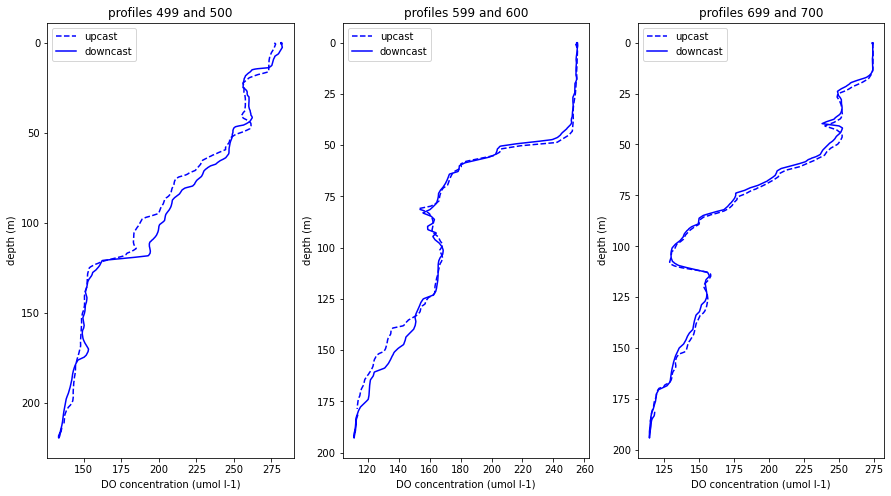

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15,8))

ax[0].plot(df.DOsp[df.profile_index==500.0][df.depth[df.profile_index==500.0]-2 > 0]+20.57722075019967,df.depth[df.profile_index==500.0][df.depth[df.profile_index==500.0]-2 > 0]-2,'b--', label='upcast')
ax[0].plot(df.DOsp[df.profile_index==499.0][df.depth[df.profile_index==499.0]-2 > 0]+20.57722075019967,df.depth[df.profile_index==499.0][df.depth[df.profile_index==499.0]-2 > 0]-2,'b', label='downcast')
ax[0].legend()
ax[0].set_title('profiles 499 and 500')
ax[0].set_ylabel('depth (m)')
ax[0].set_xlabel('DO concentration (umol l-1)')
ax[0].invert_yaxis()

ax[1].plot(df.DOsp[df.profile_index==600.0][df.depth[df.profile_index==600.0]-2 > 0]+20.57722075019967,df.depth[df.profile_index==600.0][df.depth[df.profile_index==600.0]-2 > 0]-2,'b--', label='upcast')
ax[1].plot(df.DOsp[df.profile_index==599.0][df.depth[df.profile_index==599.0]-2 > 0]+20.57722075019967,df.depth[df.profile_index==599.0][df.depth[df.profile_index==599.0]-2 > 0]-2,'b', label='downcast')
ax[1].legend()
ax[1].set_title('profiles 599 and 600')
ax[1].set_ylabel('depth (m)')
ax[1].set_xlabel('DO concentration (umol l-1)')
ax[1].invert_yaxis()

ax[2].plot(df.DOsp[df.profile_index==700.0][df.depth[df.profile_index==700.0]-2 > 0]+20.57722075019967,df.depth[df.profile_index==700.0][df.depth[df.profile_index==700.0]-2 > 0]-2,'b--', label='upcast')
ax[2].plot(df.DOsp[df.profile_index==699.0][df.depth[df.profile_index==699.0]-2 > 0]+20.57722075019967,df.depth[df.profile_index==699.0][df.depth[df.profile_index==699.0]-2 > 0]-2,'b', label='downcast')
ax[2].legend()
ax[2].set_title('profiles 699 and 700')
ax[2].set_ylabel('depth (m)')
ax[2].set_xlabel('DO concentration (umol l-1)')
ax[2].invert_yaxis()

#### How does the slow response time of the sensor affect the differences between the two profiles? 
The slow responce time of the sensor is the most obvious in the difference between profiles 499 and 500. Between depths of 50 and 125 m a significant smearing effect due to lag can be seen, with the upcast measuring lower DO concentrations and the downcast measureing higher DO concentrations. This is because the upcast is reporting values from lower down than its stated depth (were the DO concetration is smaller) and this downcast is reporting values from higher up (where the DO concentration is higher).

#### Where in the water column is this lag effect likely to create the largest bias? Where the smallest? Why?
The largest bias will exist where the DO changes the most rapidly. The largest change will occur at the thermocline where the transition occurs between the mixed layer and the stratified layer. The smallest bias will be seen in the mixed layer since water propoerties are largely uniform in this region.